# Reconocedor de tipos de arroz

La red neuronal a desarrollar tendrá el propósito de distinguir entre cinco tipos distintos de arroz: Arborio, Bastmati, Ipsala, Jasmine y Karacadag. Para ello, se utilizará un dataset compuesto por 200 imágenes de cada una de las distintas variedades de arroz. Dicho conjunto de datos está contenido en nuestra cuenta de Google Drive, por lo que para poder acceder al mismo, es necesario montar nuestro sistema de archivos de Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora ya es accesible

Se puede comprobar que el dispositivo que se está utilizando es una GPU en **Editar / Configuración del cuaderno** o **Entorno de ejecución / Cambiar tipo de entorno de ejecución**. 

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Se muestra a continuación una imagen de ejemplo del dataset, concretamente la última imagen de la variedad "Arborio", de origen italiano.

Rice_Image_Dataset  Sign-Language


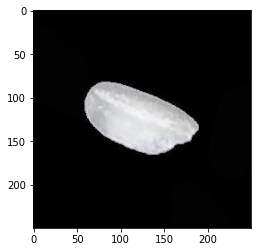

In [3]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Rice_Image_Dataset/Arborio/Arborio (200).jpg', 'r')
imshow(np.asarray(pil_im))



## Primer modelo

In [4]:
# DATA SOURCE --------------------------------------------------

image_size = (250, 250)
batch_size = 20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Rice_Image_Dataset",
    validation_split=0.2,
    subset="training",
    seed=2022,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Rice_Image_Dataset",
    validation_split=0.2,
    subset="validation",
    seed=2022,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 1000 files belonging to 5 classes.
Using 800 files for training.
Found 1000 files belonging to 5 classes.
Using 200 files for validation.


In [5]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./16),
                    offset=-1, 
                    input_shape=(250, 250, 3)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [6]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
40/40 [==============================] - 105s 2s/step - loss: 1.3846 - accuracy: 0.4725 - val_loss: 0.4770 - val_accuracy: 0.9050
Epoch 2/200
40/40 [==============================] - 2s 50ms/step - loss: 0.5397 - accuracy: 0.7812 - val_loss: 0.1925 - val_accuracy: 0.9700
Epoch 3/200
40/40 [==============================] - 2s 49ms/step - loss: 0.3465 - accuracy: 0.8413 - val_loss: 0.1155 - val_accuracy: 0.9750
Epoch 4/200
40/40 [==============================] - 2s 49ms/step - loss: 0.2539 - accuracy: 0.8900 - val_loss: 0.0840 - val_accuracy: 0.9750
Epoch 5/200
40/40 [==============================] - 2s 49ms/step - loss: 0.2107 - accuracy: 0.9062 - val_loss: 0.1121 - val_accuracy: 0.9650
Epoch 6/200
40/40 [==============================] - 2s 49ms/step - loss: 0.1897 - accuracy: 0.9325 - val_loss: 0.0649 - val_accuracy: 0.9850
Epoch 7/200
40/40 [==============================] - 2s 48ms/step - loss: 0.1846 - accuracy: 0.9262 - val_loss: 0.0621 - val_accuracy: 0.9800
Epoch 

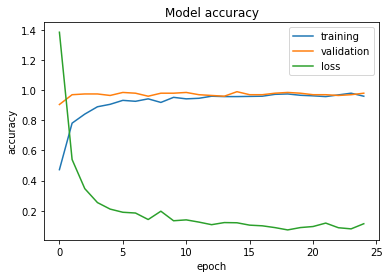

In [7]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0     0.9787    0.9787    0.9787        47
           1     1.0000    1.0000    1.0000        36
           2     0.9750    1.0000    0.9873        39
           3     1.0000    1.0000    1.0000        33
           4     1.0000    0.9778    0.9888        45

    accuracy                         0.9900       200
   macro avg     0.9907    0.9913    0.9910       200
weighted avg     0.9901    0.9900    0.9900       200



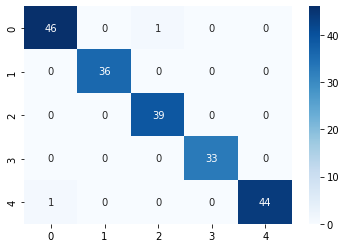

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [9]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/Rice_Image_Dataset/Ipsala/Ipsala (137).jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 72ms/step
2
